# **Notebook Projet MMPose**


**Objectif :** Je travaille sur une vidéo de danse, traitée en ***CPU-only***, et J'analye les coordonnées des points clés détectés image par image (frame par frame).

# 1. Contexte du projet



### Vidéo choisie
- **Type de mouvement** : Danse contemporaine (précise le style exact)
- **Durée** : ~21 secondes (527 frames)
- **Nombre de personnes** : 1 danseur

### Pourquoi cette vidéo ?
- Mouvements variés et dynamiques
- Une seule personne -> simplifie l'analyse
- Bonne qualité pour l'estimation de pose

### Objectifs de l'analyse
1. Extraire et visualiser les trajectoires des keypoints
2. Analyser les caractéristiques du mouvement (vitesse, accélération)
3. Identifier des patterns ou phases de mouvement
4. Préparer les données pour un modèle de prédiction

# 2. Installation et bonne utilisation de la librairie (MMPose)

Le projet a été réalisé sous Windows, dans un environnement Conda
nommé `mmpose_pip`, en mode CPU-only (sans GPU).

Les modèles utilisés sont :
- YOLOX-L pour la détection de la personne,
- HRNet-W32 pour l’estimation de pose (17 points clés, format COCO).


La commande suivante a permis de traiter la vidéo :
```bash
python demo/topdown_demo_with_mmdet.py \
yolox_l_8x8_300e_coco.py \
yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth \
td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth \
--input video_danse.mp4 \
--output-root output/ \
--device cpu \
--save-predictions

La vidéo utilisée contient une seule personne effectuant une séquence de danse. Le traitement a généré :

- output/video_danse.mp4 : vidéo (video_danse) avec squelette superposé.
- output/results_video_danse.json : fichier JSON contenant les coordonnées des points clés

# 3. Présentation, chargement et exploration des données

In [1]:
from pathlib import Path

video_path = Path("output/video_danse.mp4")
json_path  = Path("output/results_video_danse.json")

print("Video existe ?",video_path.exists(), video_path)
print("JSON existe  ?",json_path.exists(), json_path)


Video existe ? True output\video_danse.mp4
JSON existe  ? True output\results_video_danse.json


In [2]:
import json

chemin_json = Path("output/results_video_danse.json")
#Chargement des donnes
with open(chemin_json, "r", encoding="utf-8") as f:
    donnees = json.load(f)

print("dataset_name :", donnees.get("meta_info", {}).get("dataset_name"))
print("num_keypoints :", donnees.get("meta_info", {}).get("num_keypoints"))

#Liste des frames
infos_frames = donnees["instance_info"]
print("Nombre de frames :", len(infos_frames))



dataset_name : coco
num_keypoints : 17
Nombre de frames : 527


In [3]:
import numpy as np
infos_frames = donnees["instance_info"]
nb_frames = len(infos_frames)

points_cles_tous = np.zeros((nb_frames, 17, 2), dtype=np.float32)
scores_tous = np.zeros((nb_frames, 17), dtype=np.float32)

#Parcours de toutes les frames
for t, frame in enumerate(infos_frames):
    instances = frame.get("instances", [])

    #aucun humain n'est détecté
    if len(instances) == 0:
        nb_frames_vides += 1
        points_cles_tous[t] = np.nan
        scores_tous[t] = np.nan
        continue

    instance = instances[0]
    points_cles_tous[t] = np.array(instance["keypoints"])
    scores_tous[t] = np.array(instance["keypoint_scores"])


In [4]:
print("Dimensions des keypoints :", points_cles_tous.shape)
print("Score moyen :", np.nanmean(scores_tous))

Dimensions des keypoints : (527, 17, 2)
Score moyen : 0.81527567


In [5]:
print("Score min (hors NaN):", np.nanmin(scores_tous))
print("Score max (hors NaN):", np.nanmax(scores_tous))
print("Frames vides (NaN):", np.sum(np.isnan(scores_tous).all(axis=1)))

Score min (hors NaN): 0.09481777
Score max (hors NaN): 1.001099
Frames vides (NaN): 0


À chaque keypoint est associé un **score de confiance**, fourni par MMPose, qui mesure la fiabilité de la détection du point sur chaque frame.

Les résultats ci-dessus indiquent que :
- La grande majorité des keypoints sont détectés avec une **bonne confiance**
- Aucune frame vide n’a été détectée (une personne est présente sur toutes les frames)
- Certains keypoints présentent ponctuellement une faible confiance, probablement due à des mouvements rapides ou des occlusions partielles

### Données utilisées
La sortie de MMPose est un fichier JSON contenant :
- 527 frames,
- 17 points clés par frame (format COCO),
- les coordonnées (x, y) et un score de confiance par point clé.

In [6]:
keypoints_names = {
    0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear',
    5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow',
    9: 'left_wrist', 10: 'right_wrist', 11: 'left_hip', 12: 'right_hip',
    13: 'left_knee', 14: 'right_knee', 15: 'left_ankle', 16: 'right_ankle'
}

print("Les 17 keypoints détectés par MMPose (format COCO) :")
for i in range(17):
    print(f"{i} -> {keypoints_names[i]}")

Les 17 keypoints détectés par MMPose (format COCO) :
0 -> nose
1 -> left_eye
2 -> right_eye
3 -> left_ear
4 -> right_ear
5 -> left_shoulder
6 -> right_shoulder
7 -> left_elbow
8 -> right_elbow
9 -> left_wrist
10 -> right_wrist
11 -> left_hip
12 -> right_hip
13 -> left_knee
14 -> right_knee
15 -> left_ankle
16 -> right_ankle


# 4. Visualisation des premiers résultats d’estimation de pose

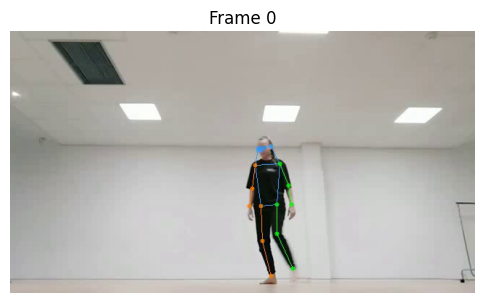

In [7]:
import cv2
import matplotlib.pyplot as plt

video_path = Path("output/video_danse.mp4")
cap = cv2.VideoCapture(str(video_path))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ok, frame = cap.read()
cap.release()
assert ok

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,4))
plt.imshow(frame_rgb)
plt.axis("off")
plt.title("Frame 0")
plt.show()


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

COCO_SKELETON = [
    (5,7), (7,9),      # bras gauche
    (6,8), (8,10),     # bras droit
    (5,6),             # épaules
    (5,11), (6,12),    # buste
    (11,12),           # hanches
    (11,13), (13,15),  # jambe gauche
    (12,14), (14,16),  # jambe droite
    (0,1), (0,2), (1,3), (2,4),  # tête
    (3,5), (4,6)       # tête -> épaules
]

In [9]:
def draw_pose_on_frame(frame_bgr, keypoints, scores=None):
    img = frame_bgr.copy()
    for a, b in COCO_SKELETON:
        if scores is not None:
            if scores[a] < 0.03 or scores[b] < 0.03:
                continue
        xa, ya = keypoints[a]
        xb, yb = keypoints[b]
        cv2.line(img, (int(xa), int(ya)), (int(xb), int(yb)), (0, 255, 0), 2)

    for i, (x, y) in enumerate(keypoints):
        if scores is not None and scores[i] < 0.03:
            continue
        cv2.circle(img, (int(x), int(y)), 3, (255, 0, 0), -1)

    return img

In [10]:
def show_pose_frame(t):
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(t))
    ok, frame = cap.read()
    cap.release()
    assert ok, f"Impossible de lire la frame {t}"

    kp = points_cles_tous[t]
    sc = scores_tous[t]

    img_pose = draw_pose_on_frame(frame, kp, sc, )
    img_pose_rgb = cv2.cvtColor(img_pose, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8,5))
    plt.imshow(img_pose_rgb)
    plt.axis("off")
    plt.title(f"frame {t} ")
    plt.show()

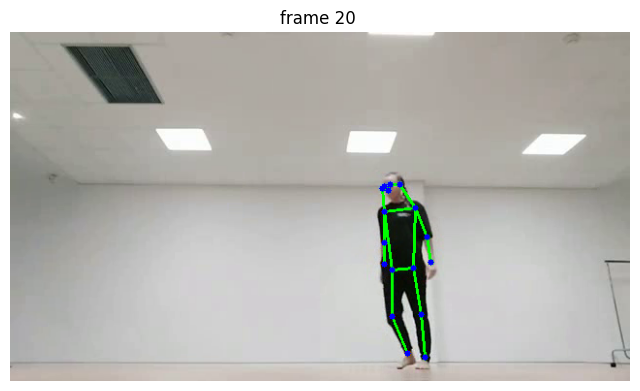

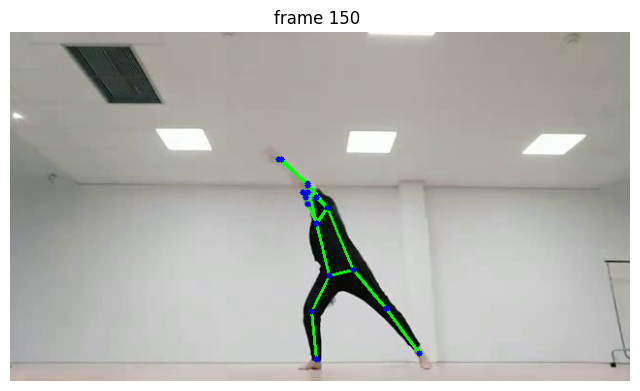

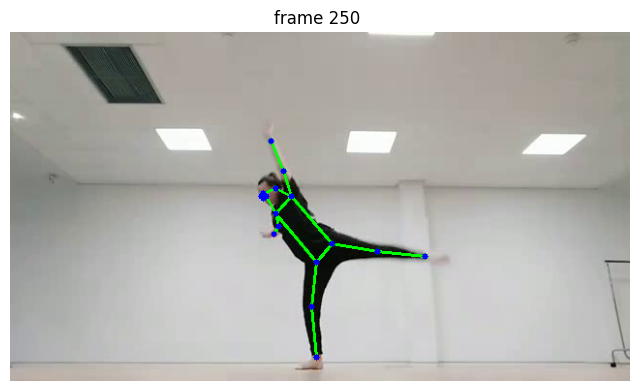

In [11]:
show_pose_frame(20)
show_pose_frame(150)
show_pose_frame(250)

# 5. Analyse des trajectoires

In [12]:
#Frames avec faible confiance
faible_confidence_frames = []
for t in range(nb_frames):
    if np.mean(scores_tous[t]) < 0.5:
        faible_confidence_frames.append(t)

print(f"\nNombre de frames avec faible confiance (<0.5) : {len(faible_confidence_frames)}")


Nombre de frames avec faible confiance (<0.5) : 1


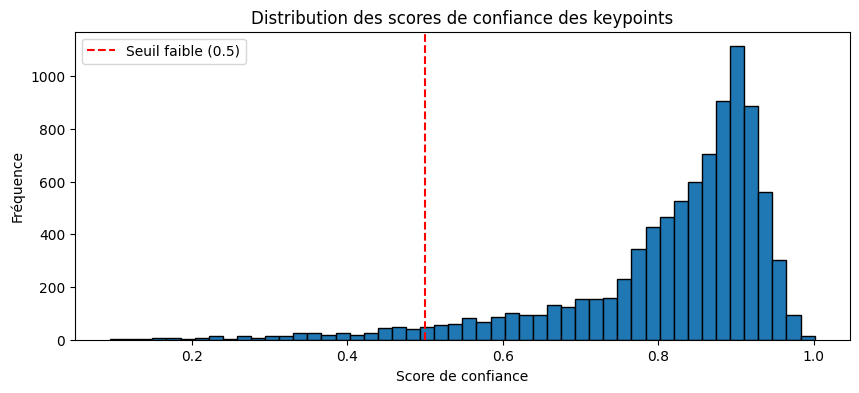

In [13]:
#distribution des scores
plt.figure(figsize=(10,4))
plt.hist(scores_tous.flatten(), bins=50, edgecolor='black')
plt.xlabel("Score de confiance")
plt.ylabel("Fréquence")
plt.title("Distribution des scores de confiance des keypoints")
plt.axvline(x=0.5, color='r', linestyle='--', label='Seuil faible (0.5)')
plt.legend()
plt.show()

La figure ci-dessus représente la distribution des scores de confiance associés à l’ensemble des keypoints détectés sur toutes les frames.
Cette distribution confirme que la détection des keypoints est globalement **fiable et stable** sur la séquence étudiée.  

**Résultats excellents :**
- Score de confiance moyen de **0.815** → Très bonne qualité globale
- Seulement **1 frame sur 527** avec une confiance < 0.5
- Cette distribution montre que MMPose a très bien fonctionné sur ma vidéo. On voit que la grande majorité des détections sont très fiables


In [14]:
id_poignet_droit = 10
#Trajectoire (x, y)
traj_poignet = points_cles_tous[:, id_poignet_droit, :]

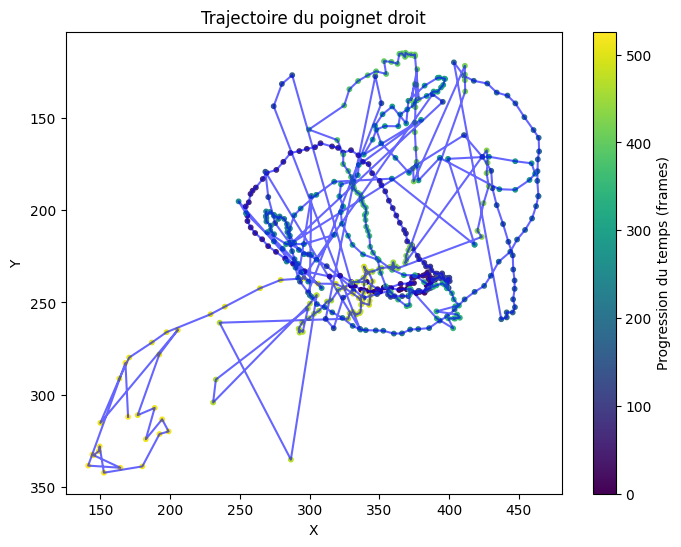

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(traj_poignet[:, 0], traj_poignet[:, 1], 'b-', alpha=0.6)
plt.scatter(traj_poignet[:, 0], traj_poignet[:, 1], c=range(len(traj_poignet)), cmap='viridis', s=10)
plt.gca().invert_yaxis()
plt.title("Trajectoire du poignet droit")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Progression du temps (frames)')
plt.show()

On observe que la trajectoire du poignet est très irrégulière.
Cela s’explique par :
- la rapidité des mouvements
- le bruit de l’estimation image par image
- l’absence de filtrage temporel
- Le traitement en mode *CPU-only* ( peut-etre)

Cette observation motive l’utilisation future de méthodes de lissage...

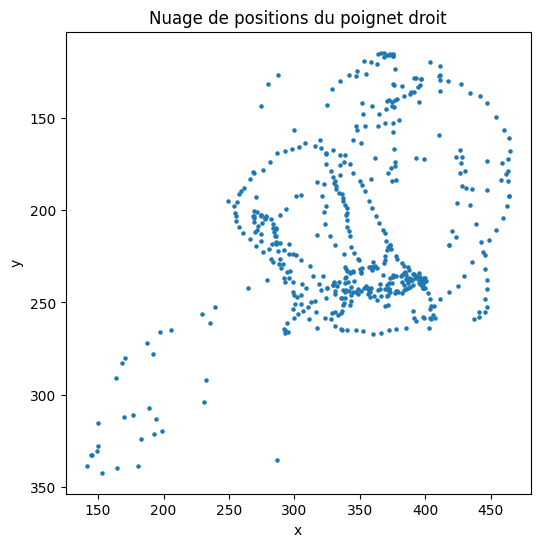

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(traj_poignet[:,0], traj_poignet[:,1], s=5)
plt.gca().invert_yaxis()
plt.title("Nuage de positions du poignet droit")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [17]:
traj = traj_poignet.copy()
x = traj[:,0]
y = traj[:,1]

def interp_nans(a):
    idx = np.arange(len(a))
    good = ~np.isnan(a)
    if good.sum() < 2:
        return a
    return np.interp(idx, idx[good], a[good])

In [18]:
x_i = interp_nans(x)
y_i = interp_nans(y)
dx = np.diff(x_i)
dy = np.diff(y_i)
vit = np.sqrt(dx*dx + dy*dy)
acc = np.diff(vit)

print("Distance totale :", float(np.sum(vit)))
print("Vitesse moyenne :", float(np.mean(vit)))
print("Vitesse max :", float(np.max(vit)))

Distance totale : 5708.807237707548
Vitesse moyenne : 10.853245699063779
Vitesse max : 143.09751932407747


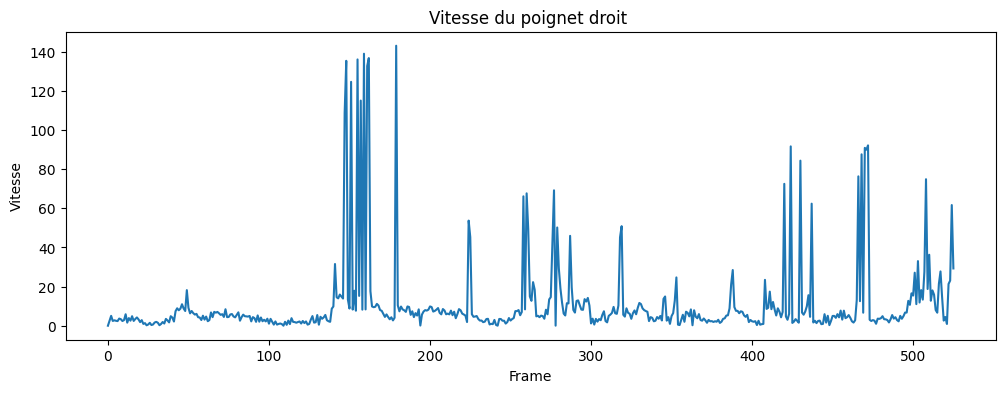

In [19]:
plt.figure(figsize=(12,4))
plt.plot(vit)
plt.title("Vitesse du poignet droit ")
plt.xlabel("Frame")
plt.ylabel("Vitesse")
plt.show()

- **Phases calmes** (frames 0-100, 200-350) : vitesse proche de zéro, poses ou transitions lentes.
- **Pics d'intensité** (frames 150-180, 400-450) : vitesses > 80 px/frame, mouvements rapides.

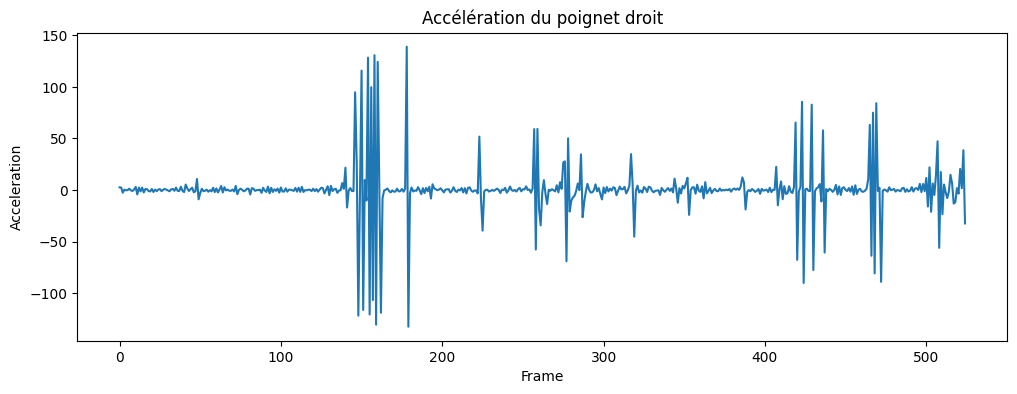

In [20]:
plt.figure(figsize=(12,4))
plt.plot(acc)
plt.title("Accélération du poignet droit")
plt.xlabel("Frame")
plt.ylabel("Acceleration")
plt.show()

- **Pics marqués** (±100-150 px/frame²) synchronisés avec les pics de vitesse
  - Pics positifs = démarrages brusques
  - Pics négatifs = arrêts ou changements de direction

In [21]:
#Calcul de la distance totale parcourue par chaque keypoint
distances_par_keypoint = {}
for i, name in keypoints_names.items():
    traj = points_cles_tous[:, i, :]
    #Calcul dess différences entre frames successives
    diff = np.diff(traj, axis=0)
    #Distance euclidienne entre chaque paire de frames
    distances = np.sqrt(np.sum(diff**2, axis=1))

    distance_totale = np.sum(distances)
    distances_par_keypoint[name] = distance_totale
#Trier par distance décroissante
distances_triees = sorted(distances_par_keypoint.items(), key=lambda x: x[1], reverse=True)

print("Distance totale parcourue par keypoint(en pixels) :")
for name, dist in distances_triees:
    print(f"{name:20s} : {dist:.2f}")

Distance totale parcourue par keypoint(en pixels) :
right_wrist          : 5708.81
left_wrist           : 4314.06
right_elbow          : 3470.74
left_elbow           : 3071.92
right_ear            : 2051.51
nose                 : 2035.51
right_eye            : 1974.69
left_eye             : 1971.71
right_ankle          : 1958.43
right_knee           : 1937.45
left_ankle           : 1918.59
left_knee            : 1918.00
left_ear             : 1889.89
right_shoulder       : 1777.91
left_shoulder        : 1771.55
left_hip             : 1597.21
right_hip            : 1441.89


Mobilité de chaque keypoint

Top 3 des keypoints les plus mobiles:

1. Poignet droit  : 5708 pixels -> Le plus dynamique
2. Poignet gauche : 4314 pixels
3. Coude droit    : 3470 pixels

-> Ce qui justifie la concentration sur l'analyse sur le poignet droit comme keypoint représentatif.

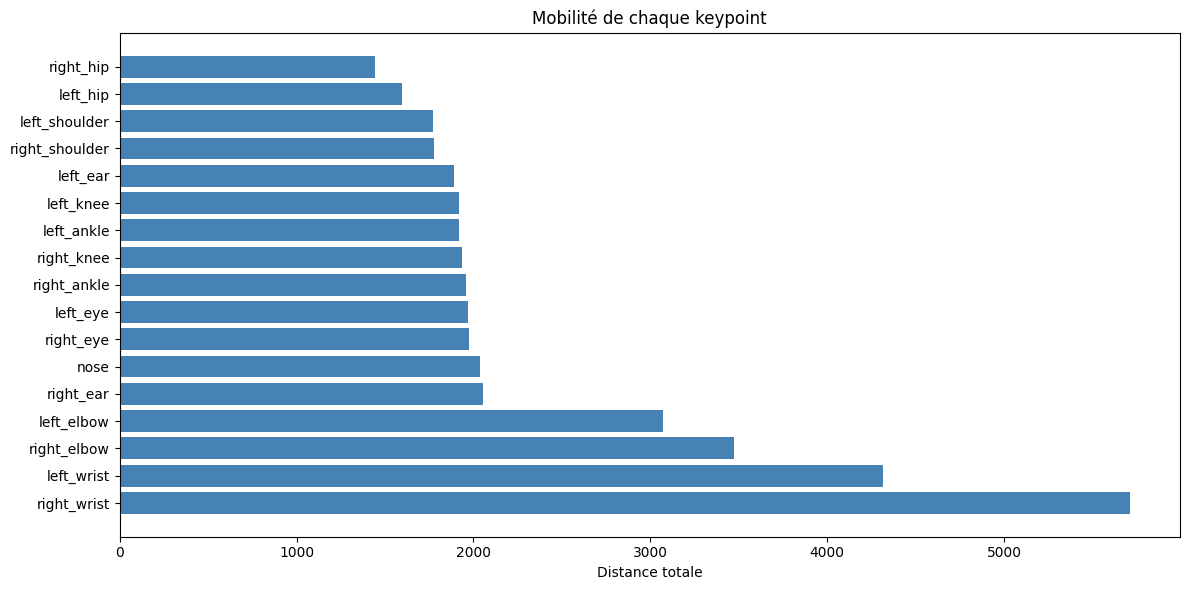

In [22]:
plt.figure(figsize=(12,6))
names = [x[0] for x in distances_triees]
dists = [x[1] for x in distances_triees]
plt.barh(names, dists, color='steelblue')
plt.xlabel("Distance totale")
plt.title("Mobilité de chaque keypoint")
plt.tight_layout()
plt.show()

In [23]:
#Utilisation de la vitesse du poignet droit
#Calcul des seuils pour classifier les phases
seuil_bas = np.percentile(vit, 25)
seuil_haut = np.percentile(vit, 75)
print("En pixels/frame : ")
print(f"Seuil vitesse basse : {seuil_bas :.2f}")
print(f"Seuil vitesse haute : {seuil_haut:.2f}")

En pixels/frame : 
Seuil vitesse basse : 2.64
Seuil vitesse haute : 8.42


In [24]:
#classification de chaque frame
phases = []
phase_colors = []
for s in vit:
    if s < seuil_bas :
        phases.append("Lent/Statique")
        phase_colors.append(0)
    elif s > seuil_haut:
        phases.append("Rapide")
        phase_colors.append(2)
    else:
        phases.append("Modéré")
        phase_colors.append(1)
# Compter les phases
from collections import Counter
phase_counts = Counter(phases)
print(f"\nRépartition des phases :")
for phase, count in phase_counts.items():
    print(f"  {phase:15s} : {count} frames ({count/len(phases)*100:.1f}%)")



Répartition des phases :
  Lent/Statique   : 132 frames (25.1%)
  Modéré          : 262 frames (49.8%)
  Rapide          : 132 frames (25.1%)


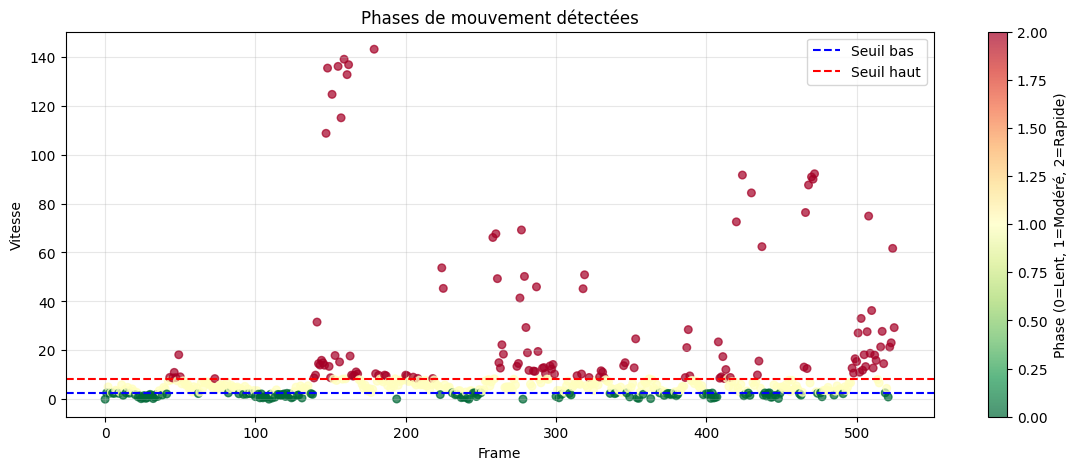

In [25]:
# Visualisation des phases
plt.figure(figsize=(14,5))
plt.scatter(range(len(vit)), vit, c=phase_colors, cmap='RdYlGn_r', s=30, alpha=0.7)
plt.axhline(y=seuil_bas , color='blue', linestyle='--', label='Seuil bas')
plt.axhline(y=seuil_haut, color='red', linestyle='--', label='Seuil haut')
plt.xlabel("Frame")
plt.ylabel("Vitesse")
plt.title("Phases de mouvement détectées")
plt.colorbar(label='Phase (0=Lent, 1=Modéré, 2=Rapide)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Le graphique montre une alternance claire entre phases :
- Zones vertes : poses, transitions lentes
- Zones rouges : mouvements explosifs
- Majorité en phase modérée (~50%)

->  Observations
- Bonne qualité d'estimation globale (score moyen : 0.81)
- Détection stable sur la majorité des frames
- Trajectoires cohérentes et exploitables

### Conclusion de l’analyse des trajectoires

Cette analyse permet de mieux comprendre la dynamique globale des mouvements au cours de la séquence, en mettant en évidence l’alternance entre phases calmes et phases rapides.
L’étude de la mobilité des keypoints montre que le poignet droit est le plus mobile, ce qui justifie le choix de se concentrer sur ce keypoint pour la suite.
Dans la suite, la prédiction est réalisée uniquement sur la trajectoire du poignet droit.
Ce choix est motivé par l’analyse précédente, qui montre que ce keypoint est le plus mobile et concentre l’essentiel de la dynamique du mouvement.

# 6. Prétraitement et analyse exploratoire des trajectoires
L’objectif de cette étape est de réduire le bruit temporel, stabiliser les trajectoires et mettre les données à une échelle comparable afin de faciliter l’apprentissage des modèles prédictifs. Le prétraitement est appliqué à la trajectoire du poignet droit, identifiée précédemment comme le keypoint le plus représentatif de la dynamique du mouvement.


## Lissage

Le lissage temporel permet d’atténuer les fluctuations brusques dues au bruit d’estimation image par image, tout en conservant la dynamique globale du mouveme


In [26]:
from scipy.signal import savgol_filter

Le filtre de Savitzky–Golay est utilisé car il permet de lisser la trajectoire tout en conservant la forme générale du mouvement et les variations importantes.
C’est une méthode de lissage qui consiste à approcher localement la trajectoire par un polynôme sur une petite fenêtre temporelle, puis à remplacer chaque point par une valeur lissée.
Il est particulièrement adapté à l’analyse de trajectoires.

In [27]:
# Paramètres du lissage
fenetre_length = 11  # fenettre de lissage -> doit etre impaire
poly_ordre = 3 #ordre du polynome 
#lissage x et y 
traj_x_lisse = savgol_filter(traj_poignet[:, 0], fenetre_length, poly_ordre)
traj_y_lisse = savgol_filter(traj_poignet[:, 1], fenetre_length, poly_ordre)
#la trajectoire lissée
trajpoignet_lisse = np.column_stack([traj_x_lisse, traj_y_lisse])


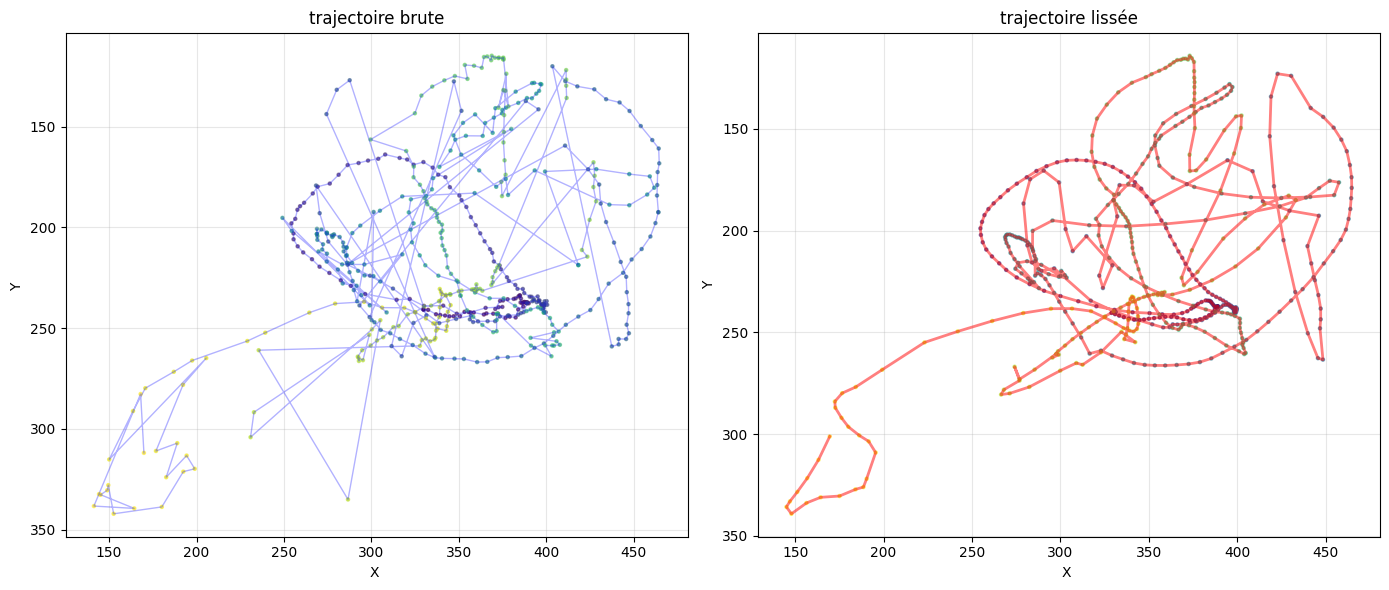

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#AVANT (brute)
axes[0].plot(traj_poignet[:, 0], traj_poignet[:, 1], 'b-', alpha=0.3, linewidth=1)
axes[0].scatter(traj_poignet[:, 0], traj_poignet[:, 1], 
                c=range(len(traj_poignet)), cmap='viridis', s=5, alpha=0.6)
axes[0].set_title('trajectoire brute', fontsize=12)
axes[0].set_xlabel('X ')
axes[0].set_ylabel('Y ')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3)
#APRES (lissee)
axes[1].plot(trajpoignet_lisse[:, 0], trajpoignet_lisse[:, 1], 'r-', alpha=0.5, linewidth=2)
axes[1].scatter(trajpoignet_lisse[:, 0], trajpoignet_lisse[:, 1], 
                c=range(len(trajpoignet_lisse)), cmap='viridis', s=5, alpha=0.6)
axes[1].set_title('trajectoire lissée', fontsize=12)
axes[1].set_xlabel('X ')
axes[1].set_ylabel('Y')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


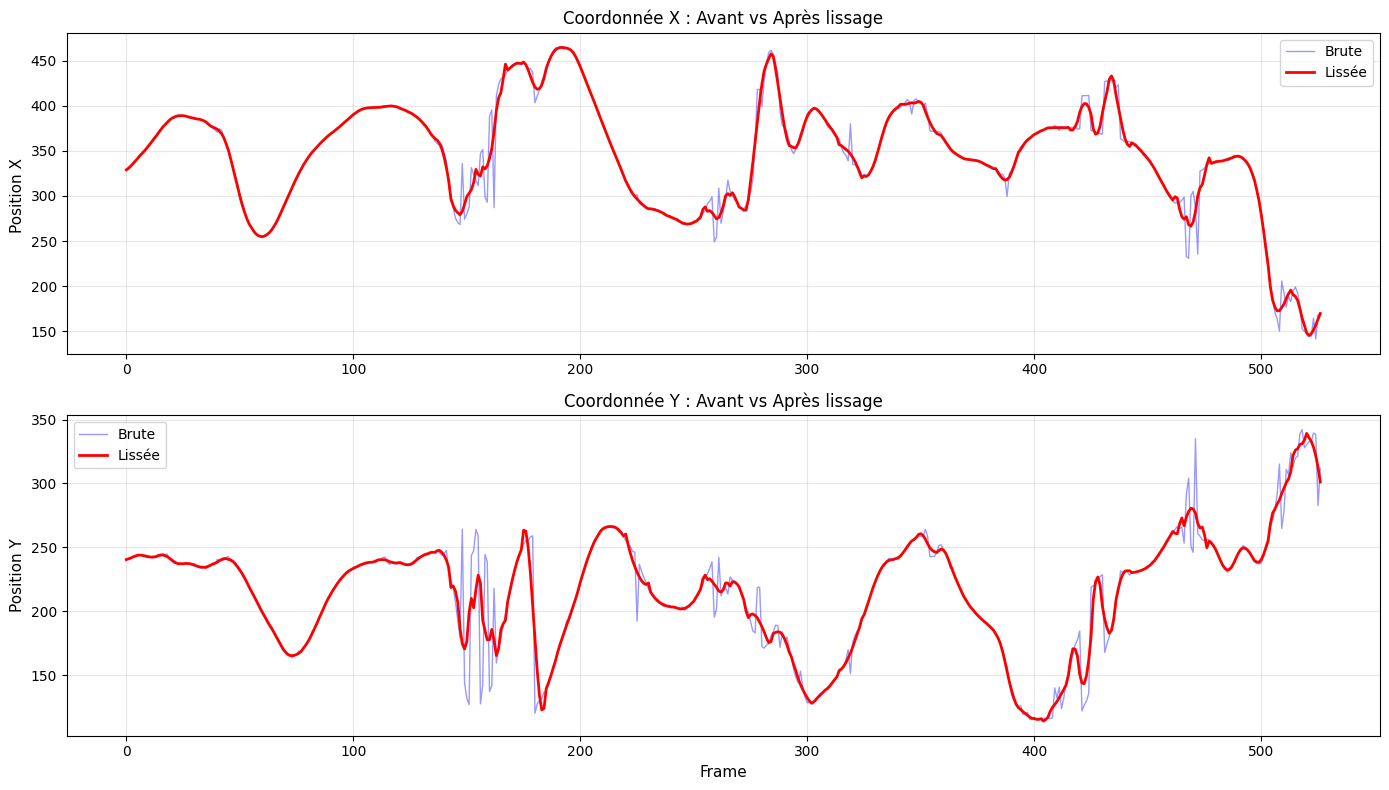

In [29]:
#X et Y séparément
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(traj_poignet[:, 0], 'b-', alpha=0.4, label='Brute', linewidth=1)
axes[0].plot(trajpoignet_lisse[:, 0], 'r-', label='Lissée', linewidth=2)
axes[0].set_ylabel('Position X ', fontsize=11)
axes[0].set_title('Coordonnée X : Avant vs Après lissage')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(traj_poignet[:, 1], 'b-', alpha=0.4, label='Brute', linewidth=1)
axes[1].plot(trajpoignet_lisse[:, 1], 'r-', label='Lissée', linewidth=2)
axes[1].set_xlabel('Frame', fontsize=11)
axes[1].set_ylabel('Position Y', fontsize=11)
axes[1].set_title('Coordonnée Y : Avant vs Après lissage')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [30]:
dx_brut = np.diff(traj_poignet[:, 0])
dy_brut = np.diff(traj_poignet[:, 1])
vitesse_brute = np.sqrt(dx_brut**2 + dy_brut**2)

dx_lisse = np.diff(trajpoignet_lisse[:, 0])
dy_lisse = np.diff(trajpoignet_lisse[:, 1])
vitesse_lisse = np.sqrt(dx_lisse**2 + dy_lisse**2)

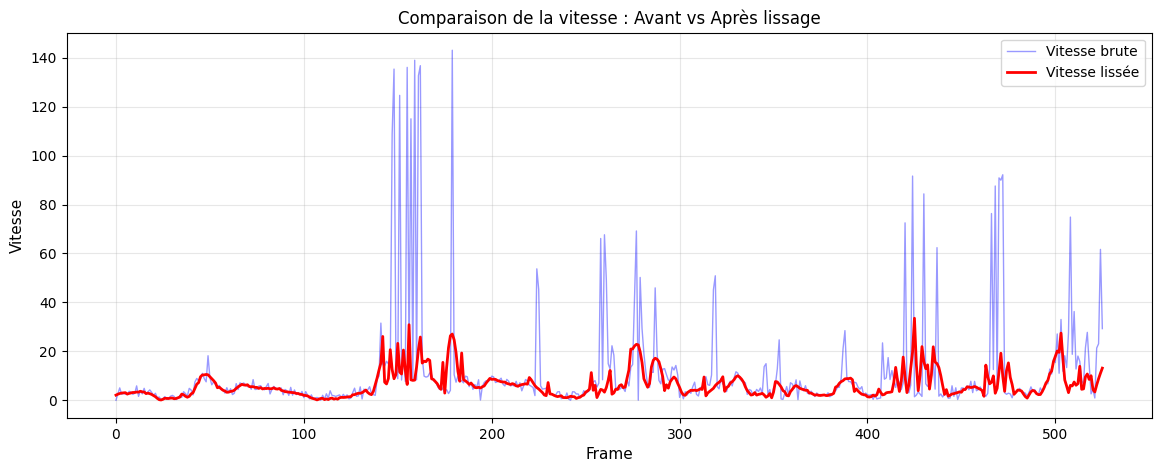

In [31]:
plt.figure(figsize=(14, 5))
plt.plot(vitesse_brute, 'b-', alpha=0.4, label='Vitesse brute', linewidth=1)
plt.plot(vitesse_lisse, 'r-', label='Vitesse lissée', linewidth=2)
plt.xlabel('Frame', fontsize=11)
plt.ylabel('Vitesse', fontsize=11)
plt.title('Comparaison de la vitesse : Avant vs Après lissage')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Le lissage permet d’obtenir une trajectoire plus stable et une vitesse plus représentative du mouvement réel. Ce prétraitement est donc essentiel avant la phase de prédiction, afin d’éviter que le modèle n’apprenne le bruit plutôt que la dynamique du mouvement.

## Normalisation

In [32]:
from sklearn.preprocessing import StandardScaler

La vitesse lissée est ensuite normalisée à l’aide d’une standardisation (StandardScaler).
Cette méthode consiste à recentrer les données (moyenne nulle) et à les réduire
(écart-type égal à 1).

La normalisation permet d’éviter que l’amplitude des valeurs de vitesse n’influence
l’apprentissage du modèle et améliore la stabilité et la convergence des méthodes
de prédiction utilisées par la suite.

In [33]:
scaler = StandardScaler()
X = vitesse_lisse.reshape(-1, 1)
X_scaled = scaler.fit_transform(X)

In [34]:
print("AVANT normalisation :")
print(f"  Moyenne : {X.mean():.2f}")
print(f"  Écart-type : {X.std():.2f}")

print("\nAPRÈS normalisation :")
print(f"  Moyenne : {X_scaled.mean():.2f}")
print(f"  Écart-type : {X_scaled.std():.2f}")


AVANT normalisation :
  Moyenne : 6.31
  Écart-type : 5.42

APRÈS normalisation :
  Moyenne : 0.00
  Écart-type : 1.00


# 7-Prédiction 

## 7.1- Régression linéaire

Cette première approche de prédiction repose sur une régression linéaire.  
L’objectif est de fournir un modèle de référence simple, afin de comparer ensuite ses performances.

À chaque instant, le modèle utilise une fenêtre temporelle de 10 frames consécutives de la trajectoire lissée du poignet droit pour prédire la position à la frame suivante.  


In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [36]:
#creation des séquences [t-9, t-8, ..., t] pour  prédire t+1
fenetre = 10  # on utilise les 10 dernières frames
X_reg, y_reg = [], []
for i in range(fenetre, len(trajpoignet_lisse) - 1):
    X_reg.append(trajpoignet_lisse[i-fenetre].flatten())  
    y_reg.append(trajpoignet_lisse[i+1])  #frame suivante

X_reg = np.array(X_reg)
y_reg = np.array(y_reg)


In [37]:
print(f"  Données préparées : {X_reg.shape[0]} séquences")
print(f"  Input  : {X_reg.shape} (10 frames × 2 coords)")
print(f"  Output : {y_reg.shape} (position suivante)")

  Données préparées : 516 séquences
  Input  : (516, 2) (10 frames × 2 coords)
  Output : (516, 2) (position suivante)


In [38]:
# 80% train, 20% test
split = int(0.8 * len(X_reg))

X_train, X_test = X_reg[:split], X_reg[split:]
y_train, y_test = y_reg[:split], y_reg[split:]


In [39]:
print(f"Train : {len(X_train)} séquences")
print(f"Test  : {len(X_test)} séquences")

Train : 412 séquences
Test  : 104 séquences


Les données ont été divisées en deux ensembles : 80 % pour l’apprentissage et 20 % pour le test, ce qui permet d’évaluer la capacité de généralisation du modèle.  
Le jeu d’entraînement contient 412 séquences, tandis que le jeu de test en contient 104.  

In [40]:
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)
y_pred_lin = reg_lin.predict(X_test)


In [41]:

mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"Régression LINÉAIRE : ")
print(f"   MSE : {mse_lin:.2f} pixels^2")
print(f"   RMSE : {np.sqrt(mse_lin):.2f} pixels")

Régression LINÉAIRE : 
   MSE : 2726.52 pixels^2
   RMSE : 52.22 pixels


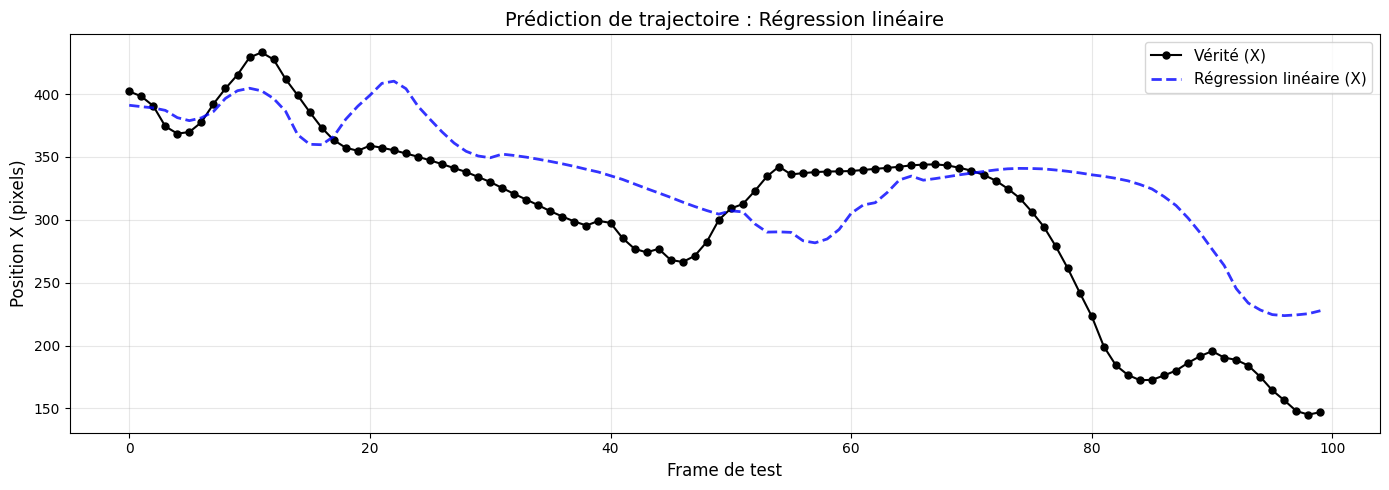

In [42]:
n_show = 100

plt.figure(figsize=(14, 5))
frames_test = range(len(y_test[:n_show]))

plt.plot(frames_test, y_test[:n_show, 0], 'ko-', label='Vérité (X)', markersize=5, linewidth=1.5)
plt.plot(frames_test, y_pred_lin[:n_show, 0], 'b--', label='Régression linéaire (X)', linewidth=2, alpha=0.8)
plt.xlabel('Frame de test', fontsize=12)
plt.ylabel('Position X (pixels)', fontsize=12)
plt.title('Prédiction de trajectoire : Régression linéaire', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [43]:

print(f"\n Résultat final :")
print(f"   RMSE = {np.sqrt(mse_lin):.2f} pixels")
print(f"   Erreur moyenne : ~{np.sqrt(mse_lin):.0f} pixels par prédiction")


 Résultat final :
   RMSE = 52.22 pixels
   Erreur moyenne : ~52 pixels par prédiction


La régression linéaire a été évaluée sur le jeu de test à l’aide de l’erreur quadratique moyenne (MSE) et de la racine de cette erreur (RMSE).

Le modèle obtient une MSE de 2726.52 pixels², correspondant à une RMSE d’environ 52 pixels.  
Cela signifie qu’en moyenne, la position prédite du poignet droit s’écarte d’environ 52 pixels de la position réelle.

Ce résultat montre que la régression linéaire parvient à capturer une tendance globale du mouvement, mais reste insuffisante pour prédire précisément la trajectoire, en particulier lors des mouvements rapides ou non linéaires.  
Ces limites s’expliquent par la nature linéaire du modèle, qui ne permet pas de modéliser correctement la dynamique temporelle complexe du geste.


Ces observations motivent l’utilisation d’un modèle séquentiel plus avancé, tel que le LSTM, capable de mieux exploiter les dépendances temporelles et la non-linéarité des trajectoires.


## 7.2- LSTM (simple) avec PyToch

L’entraînement du modèle LSTM a été réalisé dans un environnement Python différent de celui utilisé précédemment (mmpose_pip).
En effet, PyTorch ne fonctionnait pas correctement dans l’environnement mmpose_pip, ce qui empêchait l’entraînement du modèle.

Un environnement dédié compatible avec PyTorch a donc été utilisé. Les données prétraitées ont été sauvegardées puis rechargées dans ce nouvel environnement afin de poursuivre l’apprentissage sans modifier le pipeline de données.

In [44]:
# Sauvegarder les données nécessaires
import pickle

donnees_lstm = {
    'trajpoignet_lisse': trajpoignet_lisse,
    'trajpoignet_brut': traj_poignet,
    'vitesse_lisse': vitesse_lisse,
    'X_scaled': X_scaled
}

with open('donne_pour_lstm.pkl', 'wb') as f:
    pickle.dump(donnees_lstm, f)


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
with open('donnees_pour_lstm.pkl', 'rb') as f:
    donnees = pickle.load(f)

trajpoignet_lisse = donnees['trajpoignet_lisse']
trajpoignet = donnees['trajpoignet_brut']
nb_frames = len(trajpoignet_lisse)


In [5]:
print("Données chargées avec succès ")
print(f"   Trajectoire lissée : {trajpoignet_lisse.shape}")
print(f"   Trajectoire brute : {trajpoignet.shape}")
print(f"   Nombre de frames : {nb_frames}")

Données chargées avec succès 
   Trajectoire lissée : (527, 2)
   Trajectoire brute : (527, 2)
   Nombre de frames : 527


In [6]:
# Test PyTorch
import torch
import torch.nn as nn
print(f"   Version : {torch.__version__}")

   Version : 2.0.1+cpu


In [7]:
from sklearn.preprocessing import MinMaxScaler

seq_length = 10 # 10 frames passées pour prédire la suivante
n_future = 1

scaler = MinMaxScaler()
traj_normalized = scaler.fit_transform(trajpoignet_lisse)

Une nouvelle normalisation est appliquée avant l’entraînement du LSTM.
Contrairement aux modèles précédents, le LSTM est entraîné directement sur des séquences temporelles et est très sensible à l’échelle des données.
Les trajectoires sont donc normalisées avec un MinMaxScaler afin de garantir une convergence stable et un apprentissage efficace.

In [8]:
X_lstm, y_lstm = [], []

for i in range(seq_length, len(traj_normalized) - n_future):
    X_lstm.append(traj_normalized[i-seq_length:i])
    y_lstm.append(traj_normalized[i])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

In [9]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [10]:
# Split 80/20
split = int(0.8 * len(X_lstm))

X_train = torch.FloatTensor(X_lstm[:split])
X_test = torch.FloatTensor(X_lstm[split:])
y_train = torch.FloatTensor(y_lstm[:split])
y_test = torch.FloatTensor(y_lstm[split:])


Les trajectoires normalisées sont découpées en séquences de 10 frames pour entraîner le LSTM à prédire la position suivante.
Un découpage 80 % / 20 % est appliqué pour l’entraînement et le test.

In [11]:
print(f"  Train : {len(X_train)} séquences")
print(f"  Test  : {len(X_test)} séquences")

  Train : 412 séquences
  Test  : 104 séquences


In [518]:
set_seed(42)
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 2)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

model = LSTMModel()
print(f"Modèle creé : {sum(p.numel() for p in model.parameters())} paramètres")


Modèle creé : 17538 paramètres


Un LSTM à une couche est utilisé pour modéliser la dynamique temporelle des trajectoires. 
À partir d'une séquence de 10 frames, le modèle prédit directement la position suivante (x, y). 
Le modèle contient 17 538 paramètres, ce qui reste raisonnable au regard de la taille 
du jeu de données.


In [537]:
#configuration
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 300
train_losses = []
val_losses = []
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    # Train
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test).item()
    val_losses.append(val_loss)

print("Entraînement terminé !")


Entraînement terminé !


Le modèle a été entraîné pendant 400 epochs avec un learning rate de 0.001, ce qui 
s'est avéré suffisant pour atteindre une bonne convergence


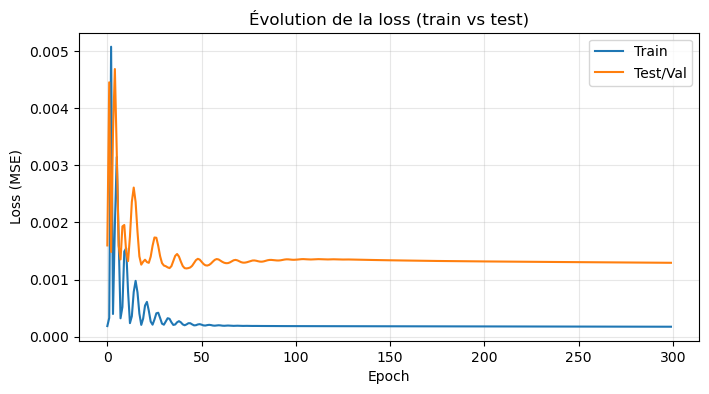

In [538]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Test/Val")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Évolution de la loss (train vs test)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


La figure ci-dessus présente l'évolution de la loss (MSE) sur les ensembles d'entraînement 
et de test. On observe une convergence rapide du modèle, avec une loss d'entraînement faible 
et une loss de validation qui se stabilise sans divergence, indiquant une bonne généralisation. 
L'écart entre les deux courbes reste modéré, ce qui suggère l'absence d'overfitting significatif.


In [539]:
# Évaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Dénormaliser
y_test_denorm = scaler.inverse_transform(y_test.numpy())
y_pred_denorm = scaler.inverse_transform(y_pred.numpy())

# MSE
mse_lstm = mean_squared_error(y_test_denorm, y_pred_denorm)
rmse_lstm = np.sqrt(mse_lstm)

print(f" RÉSULTATS LSTM :")
print(f"  MSE  : {mse_lstm:.2f} pixels^2")
print(f"  RMSE : {rmse_lstm:.2f} pixels")



 RÉSULTATS LSTM :
  MSE  : 104.34 pixels^2
  RMSE : 10.21 pixels


Le modèle LSTM obtient une erreur quadratique moyenne (RMSE) de 10.21 pixels sur le jeu de test, ce qui constitue une amélioration significative par rapport à la régression linéaire (RMSE = 52 pixels).
Cette différence s’explique par la capacité du LSTM à modéliser les dépendances temporelles entre les positions successives.

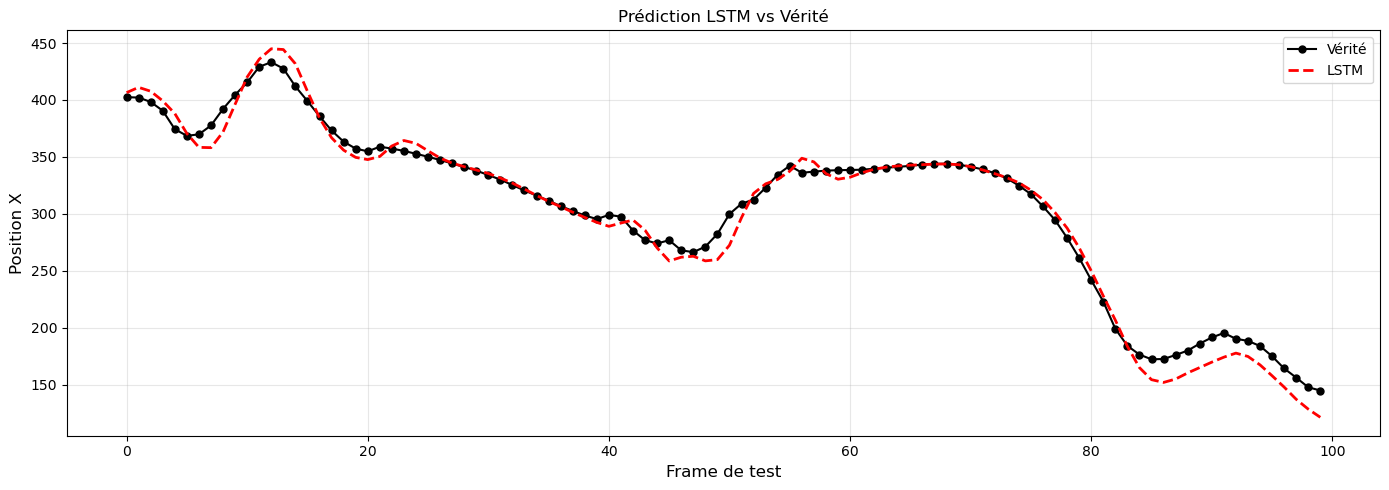

In [540]:
n_show = 100
plt.figure(figsize=(14, 5))
plt.plot(range(n_show), y_test_denorm[:n_show, 0], 'ko-', label='Vérité', markersize=5)
plt.plot(range(n_show), y_pred_denorm[:n_show, 0], 'r--', label='LSTM', linewidth=2)
plt.xlabel('Frame de test', fontsize=12)
plt.ylabel('Position X', fontsize=12)
plt.title('Prédiction LSTM vs Vérité')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

La comparaison entre la trajectoire prédite et la trajectoire réelle montre que le LSTM 
suit correctement la dynamique globale du mouvement. Les principales erreurs apparaissent 
lors de changements rapides de direction ou de vitesse, ce qui est attendu pour un modèle 
simple à une couche.

Le LSTM capture efficacement les tendances à moyen terme, contrairement à la régression 
linéaire qui échoue à modéliser les variations non-linéaires du mouvement.

### Validation de la Robustesse du LSTM

Pour vérifier la stabilité des résultats du LSTM face aux initialisations aléatoires, 
je réentraîne le modèle 9 fois supplémentaires (le premier résultat) est conservé.


In [16]:
#fonction pour réentraîner le LSTM 
def reentrainer_lstm(seed):
    set_seed(seed)  #on utilise ta fonction set_seed existante
    
    # Même architecture 
    class LSTMModel(nn.Module):
        def __init__(self):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size=2, hidden_size=64, num_layers=2, 
                                dropout=0.2, batch_first=True)
            self.fc = nn.Linear(64, 2)
        
        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            return self.fc(lstm_out[:, -1, :])
    
    model = LSTMModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # meme données déjà crees
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    #entraînement
    model.train()
    for epoch in range(300):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
    
    #dénormalisation
    y_test_denorm = scaler.inverse_transform(y_test.numpy())
    y_pred_denorm = scaler.inverse_transform(y_pred_test.numpy())
    
    # RMSE
    rmse = np.sqrt(np.mean((y_test_denorm - y_pred_denorm)**2))
    return rmse


rmse_lstm_original = 10.21  #mon premier resultat dans la partie precedente

rmse_lstm_tous = [rmse_lstm_original]  #

In [ ]:
print("Calcul de l'intervalle de confiance pour le LSTM :")
print(f"Run 1/10 : RMSE = {rmse_lstm_original:.2f}")

#Ajout 9 nouveaux 
for i in range(2, 11):
    seed = 42 + i
    rmse = reentrainer_lstm(seed)
    rmse_lstm_tous.append(rmse)
    print(f"Run {i}/10 : RMSE = {rmse:.2f} pixels")

rmse_mean_lstm = np.mean(rmse_lstm_tous)
rmse_std_lstm = np.std(rmse_lstm_tous)
rmse_ci_lstm = 1.96 * rmse_std_lstm  # IC 95%

Calcul de l'intervalle de confiance pour le LSTM :
Run 1/10 : RMSE = 10.21
Run 2/10 : RMSE = 10.10 pixels
Run 3/10 : RMSE = 7.67 pixels
Run 4/10 : RMSE = 10.68 pixels
Run 5/10 : RMSE = 11.17 pixels
Run 6/10 : RMSE = 14.98 pixels
Run 7/10 : RMSE = 10.00 pixels
Run 8/10 : RMSE = 12.61 pixels
Run 9/10 : RMSE = 10.98 pixels
Run 10/10 : RMSE = 14.98 pixels
 RÉSULTATS LSTM (n=10 runs incluant mon original (le premier) ) :
   RMSE moyen : 11.34 ± 4.24 pixels (IC 95%)
   Min : 7.67 | Max : 14.98


In [25]:
print(f" RÉSULTATS LSTM (n=10 runs incluant mon original (le premier) ) :")
print(f"   RMSE moyen : {rmse_mean_lstm:.2f} ± {rmse_ci_lstm:.2f} pixels (IC 95%)")
print(f"   Écart-type : {rmse_std_lstm:.2f} pixels")
print(f"   Min : {np.min(rmse_lstm_tous):.2f} | Max : {np.max(rmse_lstm_tous):.2f}")

 RÉSULTATS LSTM (n=10 runs incluant mon original (le premier) ) :
   RMSE moyen : 11.34 ± 4.24 pixels (IC 95%)
   Écart-type : 2.16 pixels
   Min : 7.67 | Max : 14.98


Les 10 entraînements révèlent une **forte variabilité** :
- RMSE moyen : **11.34 ± 4.24 pixels** (IC 95%)
- Écart min-max : **7.31 pixels** (de 7.67 à 14.98)

**Observations :**
- Run 3 excellent (7.67 pixels) grâce à une initialisation favorable
- Runs 6 et 10 mauvais (14.98 pixels) -> convergence vers minimum local sous-optimal
- Mon premier résultat (10.21) était proche de la moyenne 

**Interprétation :** Le LSTM est sensible aux initialisations aléatoires sur un petit dataset (527 frames pour 17 500 paramètres). La forte variabilité indique un risque d'overfitting selon l'initialisation choisie.

#### Conclusion LSTM

Ces résultats montrent que le LSTM est bien adapté à la prédiction de trajectoires à 
court terme et constitue une amélioration nette par rapport aux modèles non temporels.

**Points clés :**
- RMSE de 10.21 pixels (mieux que la régression linéaire)
- Convergence stable sans overfitting (prouvé par la courbe train/test loss)

## 7.3 GRU

GRU (Gated Recurrent Unit) est une variante plus légère du LSTM, avec moins de paramètres et une structure plus simple.
Comme pour le LSTM, on découpe la trajectoire en séquences de 10 frames pour prédire la position suivante (x, y).
Les données étant sensibles à l’échelle, on conserve la normalisation MinMax déjà utilisée pour le LSTM, puis on dénormalise les prédictions pour calculer l’erreur en pixels.

In [ ]:
set_seed(42)
class model_gru(nn.Module):
    def __init__(self):
        super(model_gru, self).__init__()
        self.gru = nn.GRU(input_size=2, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 2)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.fc(gru_out[:, -1, :])
        return output

# Créer le modèle
model = model_gru()

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())

print(f"Modèle créé : {total_params} paramètres")


Modèle créé : 13186 paramètres


Le modèle GRU utilise la même architecture que le LSTM mais avec une structure interne plus simple. Le même seed (42) est utilisé pour une comparaison équitable.

In [554]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train
    model.train()
    pred_train = model(X_train)
    loss_train = criterion(pred_train, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    train_losses.append(loss_train.item())

    # Val/Test (sans gradient)
    model.eval()
    with torch.no_grad():
        pred_val = model(X_test)
        loss_val = criterion(pred_val, y_test).item()
    val_losses.append(loss_val)

print("Entraînement GRU terminé !")


Entraînement GRU terminé !


Le modèle GRU a été entraîné pendant 300 epochs avec les mêmes hyperparamètres que le LSTM (Adam, lr=0.001).


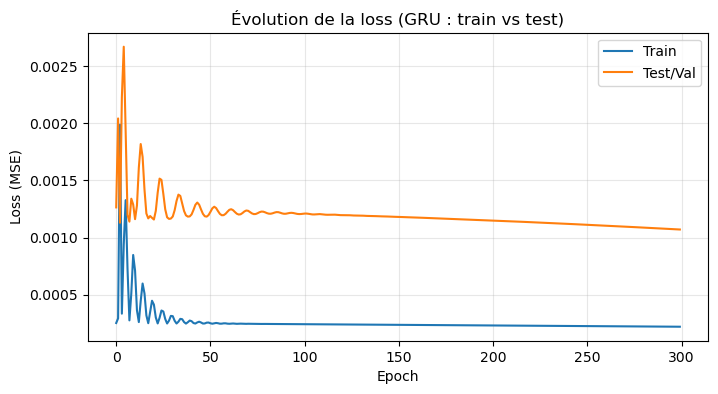

In [555]:
# Courbe de loss
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Test/Val")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Évolution de la loss (GRU : train vs test)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

La courbe de loss montre :
- Une convergence rapide et stable
- Train loss proche de 0
- Test/Val loss stable autour de 0.0012
- Généralisation sans overfitting


In [556]:
model.eval()
with torch.no_grad():
    y_pred_gru = model(X_test)

y_pred_gru_denorm = scaler.inverse_transform(y_pred_gru.numpy())

mse_gru = mean_squared_error(y_test_denorm, y_pred_gru_denorm)
rmse_gru = np.sqrt(mse_gru)

print("RÉSULTATS GRU :")
print(f" MSE  : {mse_gru:.2f} pixels^2")
print(f" RMSE : {rmse_gru:.2f} pixels")

RÉSULTATS GRU :
 MSE  : 95.62 pixels^2
 RMSE : 9.78 pixels


Le modèle GRU obtient une RMSE de **9.78 pixels**, légèrement meilleure que le LSTM (10.21 pixels). Cela représente une amélioration par rapport à la régression linéaire.
Le GRU, avec sa structure plus simple, généralise mieux sur ce dataset relativement petit.


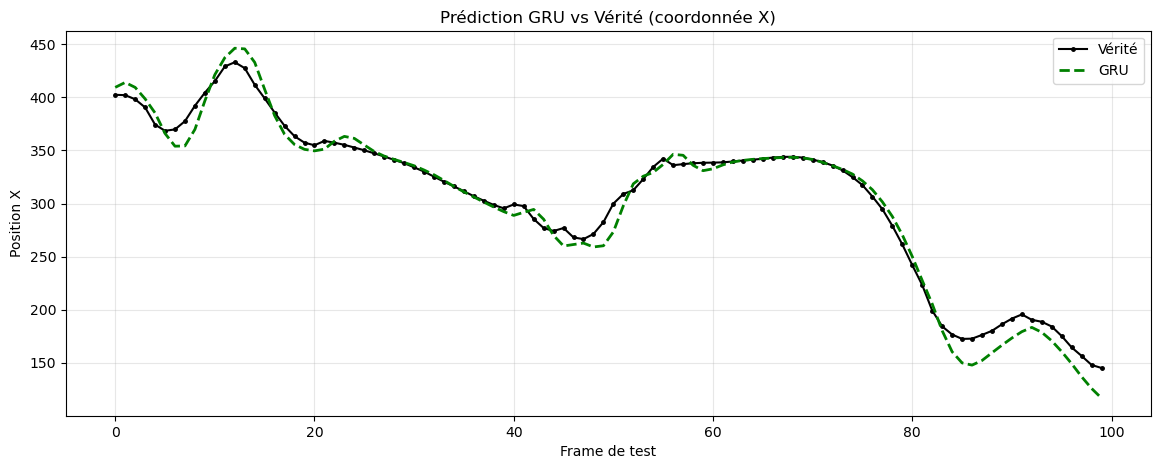

In [558]:
n_show = 100
plt.figure(figsize=(14,5))
plt.plot(range(n_show), y_test_denorm[:n_show, 0], "k.-", label="Vérité", markersize=5)
plt.plot(range(n_show), y_pred_gru_denorm[:n_show, 0], "g--", label="GRU", linewidth=2)
plt.xlabel("Frame de test")
plt.ylabel("Position X")
plt.title("Prédiction GRU vs Vérité (coordonnée X)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Les prédictions du GRU (en vert) se superposent presque parfaitement aux trajectoires réelles. Le modèle capture avec précision les mouvements complexes de la danse.

### Validation de la Robustesse du GRU

Même analyse pour le GRU : 9 nouveaux entraînements, le premier résultat est conservé.



In [20]:
#réentraîner le GRU
def reentrainer_gru(seed):
    set_seed(seed)

    class GRUModel(nn.Module):
        def __init__(self):
            super(GRUModel, self).__init__()
            self.gru = nn.GRU(input_size=2, hidden_size=64, num_layers=2, 
                              dropout=0.2, batch_first=True)
            self.fc = nn.Linear(64, 2)
        
        def forward(self, x):
            gru_out, _ = self.gru(x)
            return self.fc(gru_out[:, -1, :])
    
    model = GRUModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model.train()
    for epoch in range(300):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
    

    y_test_denorm = scaler.inverse_transform(y_test.numpy())
    y_pred_denorm = scaler.inverse_transform(y_pred_test.numpy())
    
    rmse = np.sqrt(np.mean((y_test_denorm - y_pred_denorm)**2))
    return rmse


rmse_gru_original = 9.78  # resultat precedent

rmse_gru_tous = [rmse_gru_original]

In [ ]:
print("Calcul de l'intervalle de confiance pour le GRU : ")
print(f"Run 1/10 : RMSE = {rmse_gru_original:.2f}")

for i in range(2, 11):
    seed = 42 + i
    rmse = reentrainer_gru(seed)
    rmse_gru_tous.append(rmse)
    print(f"Run {i}/10 : RMSE = {rmse:.2f} pixels")

rmse_mean_gru = np.mean(rmse_gru_tous)
rmse_std_gru = np.std(rmse_gru_tous)
rmse_ci_gru = 1.96 * rmse_std_gru

print(f"RÉSULTATS GRU (n=10 runs) :")
print(f"   RMSE moyen : {rmse_mean_gru:.2f} ± {rmse_ci_gru:.2f} pixels (IC 95%)")
print(f"   Min : {np.min(rmse_gru_tous):.2f} | Max : {np.max(rmse_gru_tous):.2f}")

Calcul de l'intervalle de confiance pour le GRU : 
Run 1/10 : RMSE = 9.78
Run 2/10 : RMSE = 9.06 pixels
Run 3/10 : RMSE = 7.75 pixels
Run 4/10 : RMSE = 9.22 pixels
Run 5/10 : RMSE = 7.79 pixels
Run 6/10 : RMSE = 7.81 pixels
Run 7/10 : RMSE = 7.14 pixels
Run 8/10 : RMSE = 7.36 pixels
Run 9/10 : RMSE = 7.07 pixels
Run 10/10 : RMSE = 7.97 pixels
RÉSULTATS GRU (n=10 runs) :
   RMSE moyen : 8.10 ± 1.74 pixels (IC 95%)
   Min : 7.07 | Max : 9.78


In [23]:
print(f"RÉSULTATS GRU (n=10 runs) :")
print(f"   RMSE moyen : {rmse_mean_gru:.2f} ± {rmse_ci_gru:.2f} pixels (IC 95%)")
print(f"   Écart-type : {rmse_std_gru:.2f} pixels") 
print(f"   Min : {np.min(rmse_gru_tous):.2f} | Max : {np.max(rmse_gru_tous):.2f}")

RÉSULTATS GRU (n=10 runs) :
   RMSE moyen : 8.10 ± 1.74 pixels (IC 95%)
   Écart-type : 0.89 pixels
   Min : 7.07 | Max : 9.78


Les 10 entraînements montrent une **bien meilleure stabilité** que le LSTM :
- RMSE moyen : **8.10 ± 1.74 pixels** (IC 95%)
- Écart type : **2.71 pixels** (de 7.07 à 9.78)

**Observations :**
- Tous les runs donnent des résultats homogènes (entre 7.07 et 9.78)
- Pas de runs "catastrophiques" comme avec le LSTM (qui avait 14.98)
- Mon premier résultat (9.78) était le maximum, mais reste proche de la moyenne

**Interprétation :** Le GRU est plus robuste que le LSTM grâce à :
- Moins de paramètres (~13 000 vs ~17 500) → moins d'overfitting
- Architecture plus simple -> meilleure généralisation sur petit dataset

## 7.4- Comparaison Approches 

Cette section compare les performances des trois modèles testés pour prédire les trajectoires de mouvement.

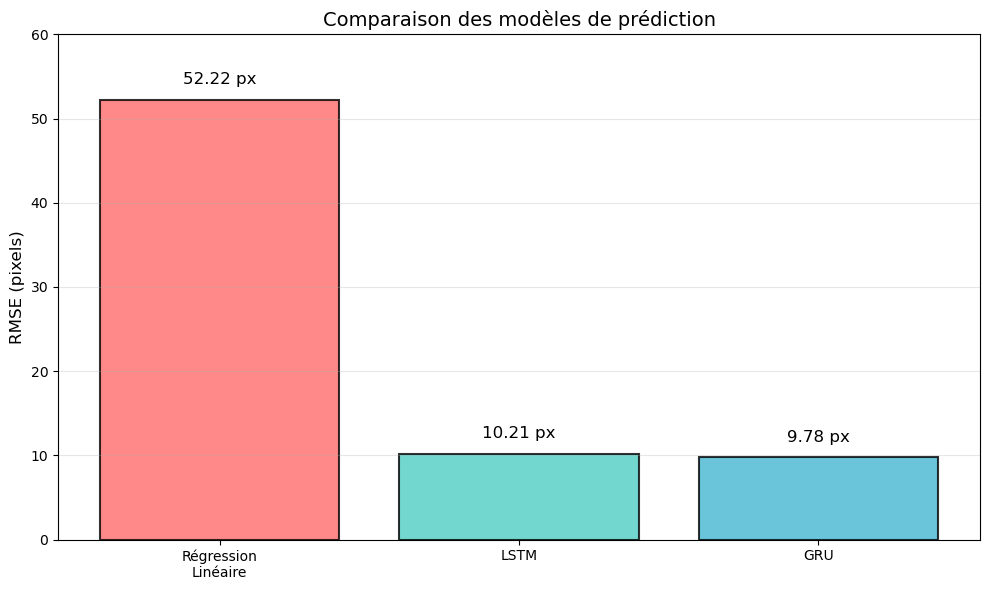

In [560]:
# Résultats
modeles = ['Régression\nLinéaire', 'LSTM', 'GRU']
rmse = [52.22, 10.21, 9.78]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']


plt.figure(figsize=(10,6))
bars = plt.bar(modeles, rmse, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)


for i, (bar, value) in enumerate(zip(bars, rmse)):
    plt.text(bar.get_x() + bar.get_width()/2, value + 1.5, 
             f'{value:.2f} px', ha='center', va='bottom', 
             fontsize=12)

plt.ylabel('RMSE (pixels)', fontsize=12)
plt.title('Comparaison des modèles de prédiction', fontsize=14)
plt.ylim(0, 60)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [564]:
print(f"{'Modèle : ':<25} {'RMSE : ':<15} ")
print(f"{'Régression Linéaire':<25} {52.22:<15.2f} ")
print(f"{'LSTM':<25} {10.21:<15.2f} ")
print(f"{'GRU':<25} {9.78:<15.2f} ")

Modèle :                  RMSE :          
Régression Linéaire       52.22           
LSTM                      10.21           
GRU                       9.78            


### Analyse comparative
**1. Régression Linéaire (52.22 pixels)** :
- Simple et rapide à entraîner
- Ne capture pas les dépendances temporelles

**2. LSTM (10.21 pixels)** :
- Excellent sur les séquences temporelles
- Plus de paramètres (~17,000)

**3. GRU (9.78 pixels)**  :
- Architecture plus simple (13,186 paramètres)
- Meilleure généralisation sur petit dataset

### Conclusion de la comparaison
Les modèles récurrents (LSTM et GRU) surpassent largement la régression linéaire grâce à leur capacité à modéliser les dépendances temporelles. Le **GRU** obtient le meilleur résultat avec une erreur de seulement **9.78 pixels**, soit une prédiction extrêmement précise des positions futures.


### Conclusion de l'analyse avec intervalles de confiance


1. **Performance** : GRU (8.10 "en moyenne") > LSTM (11.34 "en moyenne") > Linéaire (52.22)

2. **Stabilité** : GRU (±1.74) >> LSTM (±4.24)
   - Le GRU est **2.4× plus stable** que le LSTM

3. **Fiabilité en production** :
   - LSTM : Résultats imprévisibles (de 7.67 à 14.98 pixels)
   - GRU : Résultats homogènes (de 7.07 à 9.78 pixels)

**Explication scientifique :**
Le GRU surpasse le LSTM sur ce dataset limité (527 frames) car sa structure plus simple (~13 000 paramètres vs ~17 500) réduit le risque de sur-apprentissage et améliore la généralisation.

**Recommandation finale :** Le GRU est le meilleur choix pour la prédiction de trajectoires avec ce dataset.

